# 01-Train data cleanup

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

import os
os.chdir('./data')

## Data Cleaning:

### Sanity checks

In [2]:
df = pd.read_csv('offer_retailer.csv')
df.head(15)

,OFFER,RETAILER,BRAND
0,Spend $50 on a Full-Priced new Club Membership,SAMS CLUB,SAMS CLUB
1,"Beyond Meat® Plant-Based products, spend $25",NaN,BEYOND MEAT
2,Good Humor Viennetta Frozen Vanilla Cake,NaN,GOOD HUMOR
3,"Butterball, select varieties, spend $10 at Dillons Food Store",DILLONS FOOD STORE,BUTTERBALL
4,"GATORADE® Fast Twitch®, 12-ounce 12 pack, at Amazon Storefront*",AMAZON,GATORADE
5,Emmy's Organics® Cookies OR Brownie Snaps,NaN,EMMYS POP UP
6,"Dr Pepper®, Regular OR Zero Sugar Strawberries and Cream 12 pack, at select retailers",UNITED SUPERMARKETS,DR PEPPER
7,"Arnold, Brownberry, Oroweat® Small Slice bread, at Walmart",WALMART,ARNOLD BROWNBERRY OROWEAT
8,Barilla® Pesto Sauce,NaN,BARILLA
9,"Any General Mills™ products, buy 2\nGood Rewards Members Only",NaN,ANNIES HOMEGROWN GROCERY


check distribution of name length by token count

In [3]:
def token_distribution(df: pd.DataFrame, col: str):
    # get distribution of name length by token count
    df_tmp = df[[col]].dropna().drop_duplicates()
    df_tmp['TOKEN_LENGTH'] = df_tmp[col].str.split().apply(len)
    print(df_tmp.TOKEN_LENGTH.describe())
    
    # Plot histogram of token length distribution
    plt.hist(df_tmp['TOKEN_LENGTH'], bins=range(1, max(df_tmp['TOKEN_LENGTH'])+2), align='left')
    plt.xlabel('Token length')
    plt.ylabel('Frequency')
    plt.title('Distribution of token length')
    plt.show()

In [4]:
# df[df['BRAND'].str.split().apply(len) >= 4]
# df[~df.apply(lambda x: str(x["BRAND"]).lower() in x["OFFER"].lower(), axis=1)].shape
df.shape

(384, 3)

count    376.000000
mean       6.606383
std        2.735322
min        2.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       16.000000
Name: TOKEN_LENGTH, dtype: float64


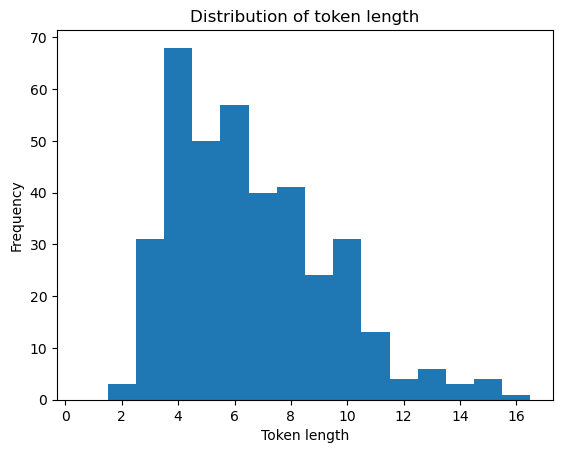

In [5]:
token_distribution(df, "OFFER")

count    144.000000
mean       1.666667
std        0.892862
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: TOKEN_LENGTH, dtype: float64


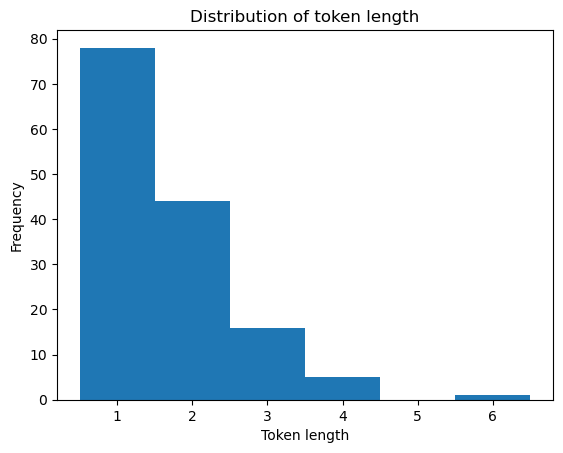

In [6]:
token_distribution(df, "BRAND")

count    61.000000
mean      1.836066
std       0.820169
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       3.000000
Name: TOKEN_LENGTH, dtype: float64


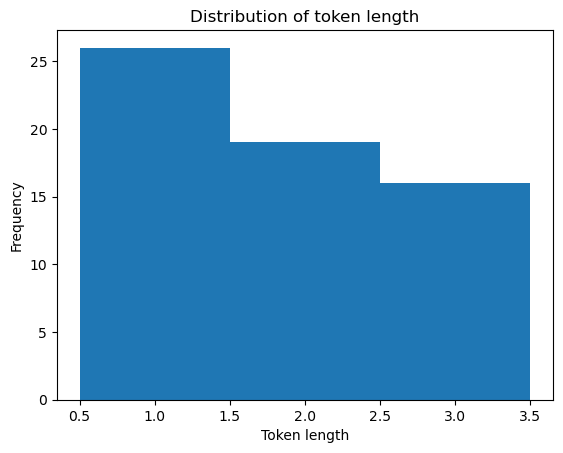

In [7]:
token_distribution(df, "RETAILER")

We see that most brand names are between 1 and 2 words and most retailer name are betwwen 1 and 3 words.

Now Check if brand/retailer names include special characters

In [8]:
import re
from typing import List

def check_special_chars(df: pd.DataFrame, col: str) -> List[str]:
    string_list = df[col].dropna().drop_duplicates().tolist()
    filtered_list = []
    for s in string_list:
        non_alnum_chars = re.findall(r'[^a-zA-Z0-9\s]', s)
        if non_alnum_chars:
            filtered_list.append(s)

    return filtered_list

In [9]:
check_special_chars(df, "BRAND")

['M&MS',
 "RAO'S",
 "MICHAEL ANGELO'S",
 'KODIAK CAKES FLAPJACK & WAFFLE MIX',
 "CAMERON'S COFFEE"]

In [10]:
check_special_chars(df, "RETAILER")

['H-E-B', 'GALLO.COM', 'SIOBEAUTY.COM', 'STOP & SHOP']

In [11]:
# df[df["RETAILER"].eq("H-E-B")|df["RETAILER"].eq("GALLO.COM")]
char_retailer = check_special_chars(df, "RETAILER")
df[df["RETAILER"].isin(char_retailer)]

,OFFER,RETAILER,BRAND
26,"Beyond Steak™ Plant-Based seared tips, 10 ounce, buy 2 at H-E-B",H-E-B,BEYOND MEAT
55,"Wine from TheBarrelRoom.com, spend $30",GALLO.COM,ALAMOS
138,"SiO® Beauty Patches, online at Siobeauty.com",SIOBEAUTY.COM,SIO BEAUTY
193,"Gorton's, at select retailers",STOP & SHOP,GORTONS
218,"Beyond Steak™ Plant-Based seared tips, 10 ounce at H-E-B",H-E-B,BEYOND MEAT
246,Gorton's at select retailers,STOP & SHOP,GORTONS


This offer doesn't include neither retailer nor brand. It tells that we have to do proper cleaning for our training data.
`Wine from TheBarrelRoom.com, spend $30	GALLO.COM	ALAMOS`

In [12]:
# "Emmy's Organics® Cookies OR Brownie Snaps",
df[df["OFFER"].eq("Emmy's Organics® Cookies OR Brownie Snaps",)]

,OFFER,RETAILER,BRAND
5,Emmy's Organics® Cookies OR Brownie Snaps,NaN,EMMYS POP UP


In [13]:
offers = check_special_chars(df, "OFFER")
offers[:10]

['Spend $50 on a Full-Priced new Club Membership',
 'Beyond Meat® Plant-Based products, spend $25',
 'Butterball, select varieties, spend $10 at Dillons Food Store',
 'GATORADE® Fast Twitch®, 12-ounce 12 pack, at Amazon Storefront*',
 "Emmy's Organics® Cookies OR Brownie Snaps",
 'Dr Pepper®, Regular OR Zero Sugar Strawberries and Cream 12 pack, at select retailers',
 'Arnold, Brownberry, Oroweat® Small Slice bread, at Walmart',
 'Barilla® Pesto Sauce',
 'Any General Mills™ products, buy 2\nGood Rewards Members Only',
 "Spend $20 at Zaxby's"]

In [14]:
df_brand = pd.read_csv('brand_category.csv')
df_brand

,BRAND,BRAND_BELONGS_TO_CATEGORY,RECEIPTS
0,CASEYS GEN STORE,Tobacco Products,2950931
1,CASEYS GEN STORE,Mature,2859240
2,EQUATE,Hair Removal,893268
3,PALMOLIVE,Bath & Body,542562
4,DAWN,Bath & Body,301844
...,...,...,...
9901,WIBBY BREWING,Beer,11
9902,LA FETE DU ROSE,Wine,11
9903,BIG ISLAND BREWHAUS,Beer,11
9904,BRIDGE LANE,Wine,11


In [15]:
# what are the special characters in the brand names? (for brand_category.csv)
check_special_chars(df_brand, "BRAND")[:20]

['COCA-COLA',
 'M&MS',
 'CRA-Z-ART',
 "KELLOGG'S",
 'COCA-COLA ZERO',
 "LAY'S",
 'HAAGEN-DAZS',
 "HELLMANN'S/BEST FOODS",
 'ARM & HAMMER',
 "M&M'S",
 "BARQ'S",
 "NATURE'S BAKERY",
 "SMUCKER'S UNCRUSTABLES",
 'FRITO-LAY',
 'ORE-IDA',
 'FISHER-PRICE',
 'RASCAL & FRIENDS',
 "MOTT'S",
 "HUNT'S",
 'CHIPS AHOY!']

### Data cleaning
We should keep `["&", ".", ",", "-"]`, and remove other special characters, and, additionally, remove  from commas from brand names

In [16]:
from typing import Dict
import copy

def clean_data(df_data:pd.DataFrame, cols: Dict[str, str]) -> pd.DataFrame:
    """
    Clean data
    Args:
        df: DataFrame
        cols: a dictionary; key 'target' is for the label, and key 'value' is for the column to be cleaned
    Returns:
        Cleaned DataFrame
    Extra note: pandas operation is slow when data is large. In furthre we can consider different data strcture or Spark.
    """
    target, col = cols['target'], cols['value']
    df = df_data[[target, col]]

    # remove all non-alphanumeric characters except in special_chars
    special_chars = ["&", ".", ",", "-", " "]
    df[target] = df[target].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
    df[col] = df[col].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
    df['idx'] = df.index # create index so that we can merge later

    # check if brand name is included in the offer; limit on name length
    is_target = df.apply(lambda x: str(x[target]).lower() in x[col].lower(), axis=1)
    # is_short_target = df.apply(lambda x: len(str(x[target]).split(" ")) <= 3, axis=1)
    # is_short_offer = df.apply(lambda x: len(x[col].split(' ')) < 13,axis=1)

    # filter
    df_cleaned = df[is_target]
    # remove all non-alphanumeric characters except in special_chars
    df_cleaned[target] = df_cleaned[target].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
    df_cleaned[col] = df_cleaned[col].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
    df_cleaned = df_cleaned.drop_duplicates()
    return df_cleaned

In [17]:
brand_cleaned = clean_data(df, {"target": "BRAND", "value": "OFFER"})
display(brand_cleaned.head())
print(brand_cleaned.shape)

/var/folders/k5/x_9mt5q1367c1vkp6jfrlcl80000gn/T/ipykernel_81885/730516147.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
/var/folders/k5/x_9mt5q1367c1vkp6jfrlcl80000gn/T/ipykernel_81885/730516147.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
/var/folders/k5/x_9mt5q1367c1vkp6jfrlcl80000gn/T/ipykernel_818

,BRAND,OFFER,idx
1,BEYOND MEAT,"Beyond Meat Plant-Based products, spend 25",1
2,GOOD HUMOR,Good Humor Viennetta Frozen Vanilla Cake,2
3,BUTTERBALL,"Butterball, select varieties, spend 10 at Dillons Food Store",3
4,GATORADE,"GATORADE Fast Twitch, 12-ounce 12 pack, at Amazon Storefront",4
6,DR PEPPER,"Dr Pepper, Regular OR Zero Sugar Strawberries and Cream 12 pack, at select retailers",6


(285, 3)


In [18]:
# # write to csv
# brand_cleaned.to_csv('brand_offer_cleaned.csv', index=False)

In [19]:
df2 = df.copy().dropna(subset=['RETAILER'])
df2.shape

(238, 3)

In [20]:
retailer_cleaned = clean_data(df2, {"target": "RETAILER", "value": "OFFER"})
display(retailer_cleaned.head())
print(retailer_cleaned.shape)

/var/folders/k5/x_9mt5q1367c1vkp6jfrlcl80000gn/T/ipykernel_81885/730516147.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
/var/folders/k5/x_9mt5q1367c1vkp6jfrlcl80000gn/T/ipykernel_81885/730516147.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: ''.join(c for c in x if c.isalnum() or c in special_chars))
/var/folders/k5/x_9mt5q1367c1vkp6jfrlcl80000gn/T/ipykernel_818

,RETAILER,OFFER,idx
3,DILLONS FOOD STORE,"Butterball, select varieties, spend 10 at Dillons Food Store",3
4,AMAZON,"GATORADE Fast Twitch, 12-ounce 12 pack, at Amazon Storefront",4
7,WALMART,"Arnold, Brownberry, Oroweat Small Slice bread, at Walmart",7
10,ALDI,Egglife Egg White Wraps at Aldi,10
11,ZAXBYS,Spend 20 at Zaxbys,11


(178, 3)


In [21]:
# # write to csv
# retailer_cleaned.to_csv('retailer_offer_cleaned.csv', index=False)

In [22]:
# merge cleaned brand and retailer data based on index; each idx is unique so 

## Prepare brand

In [23]:
# read csv
brand_cleaned = pd.read_csv('brand_offer_cleaned.csv')
brand_cleaned.head(10)

,BRAND,OFFER,idx
0,BEYOND MEAT,"Beyond Meat Plant-Based products, spend 25",1
1,GOOD HUMOR,Good Humor Viennetta Frozen Vanilla Cake,2
2,BUTTERBALL,"Butterball, select varieties, spend 10 at Dillons Food Store",3
3,GATORADE,"GATORADE Fast Twitch, 12-ounce 12 pack, at Amazon Storefront",4
4,DR PEPPER,"Dr Pepper, Regular OR Zero Sugar Strawberries and Cream 12 pack, at select retailers",6
5,BARILLA,Barilla Pesto Sauce,8
6,EGGLIFE,Egglife Egg White Wraps at Aldi,10
7,ZAXBYS,Spend 20 at Zaxbys,11
8,SUBWAY,Spend 10 at Subway,12
9,DOVE CHOCOLATE,"DOVE Chocolate, select sizes, buy 1",13


## Prepare retailer

In [25]:
# read csv
retailer_cleaned = pd.read_csv('retailer_offer_cleaned.csv')
retailer_cleaned.head(10)

,RETAILER,OFFER,idx
0,DILLONS FOOD STORE,"Butterball, select varieties, spend 10 at Dillons Food Store",3
1,AMAZON,"GATORADE Fast Twitch, 12-ounce 12 pack, at Amazon Storefront",4
2,WALMART,"Arnold, Brownberry, Oroweat Small Slice bread, at Walmart",7
3,ALDI,Egglife Egg White Wraps at Aldi,10
4,ZAXBYS,Spend 20 at Zaxbys,11
5,SUBWAY,Spend 10 at Subway,12
6,TARGET,"Beyond Steak Plant-Based seared tips, 10 ounce at Target",17
7,SHAWS,Spend 140 at Shaws,20
8,TARGET,"LOréal Paris Hair color, select varieties, spend 19 at Target",21
9,ACME,Shop 2 times at ACME,24


In [26]:
df[df["BRAND"].eq("DR PEPPER")]

,OFFER,RETAILER,BRAND
6,"Dr Pepper®, Regular OR Zero Sugar Strawberries and Cream 12 pack, at select retailers",UNITED SUPERMARKETS,DR PEPPER
